In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

sys.path.append('../modules')
from timeseries import select_months

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## read unique landslide dates
df = pd.read_csv('../out/non-landslide_dates.csv')
df = df.set_index(pd.to_datetime(df['init_date'], format='%Y-%m-%d'))
final_dates_lst = df.index

date_lst = []
impact_date_lst = []
model_lst = []
F_lst = []
for i, date in enumerate(final_dates_lst):
    ## skip 2 events - 20200227, 20200817
    ## the data from GEFS was too hard to download for these dates
    if (date.strftime("%Y%m%d") == '20200227') | (date.strftime("%Y%m%d") == '20200817'):
        pass
    else:
        for j, init_lead in enumerate(np.arange(1, 8)):
            F_lst.append(init_lead*24) # lead in hours
            init_date = date - pd.to_timedelta(init_lead, unit='D')
            date_lst.append(init_date)
            impact_date_lst.append(date)
            
            if init_date.year < 2020:
                model_name = 'GEFSv12_reforecast'
            else:
                model_name = 'GEFS_archive'
    
            model_lst.append(model_name)

d = {'impact_date': impact_date_lst, 'init_date': date_lst, 'model_name': model_lst, 'F': F_lst}
df = pd.DataFrame(d)

## cut the df so it takes out init dates before 2000-01-01
idx = (df['init_date'] >= '2000-01-01')
df = df.loc[idx]
df

,impact_date,init_date,model_name,F
7,2000-01-02,2000-01-01,GEFSv12_reforecast,24
14,2000-01-03,2000-01-02,GEFSv12_reforecast,24
15,2000-01-03,2000-01-01,GEFSv12_reforecast,48
21,2000-01-04,2000-01-03,GEFSv12_reforecast,24
22,2000-01-04,2000-01-02,GEFSv12_reforecast,48
...,...,...,...,...
50752,2019-12-31,2019-12-28,GEFSv12_reforecast,72
50753,2019-12-31,2019-12-27,GEFSv12_reforecast,96
50754,2019-12-31,2019-12-26,GEFSv12_reforecast,120
50755,2019-12-31,2019-12-25,GEFSv12_reforecast,144


In [4]:
IVT_lst = []
Z0_lst = []
UV_lst = []
QPF_lst = []
AR_index_lst = []
for index, row in df.iterrows():
    ## read csv files from landslide dates
    model_name = row['model_name']
    F = row['F']
    
    fdate = row['init_date'].strftime("%Y%m%d")
    impact_date = row['impact_date'].strftime("%Y-%m-%d")
    try:
        ## for each row, open the file using the init date
        fname = '/expanse/nfs/cw3e/cwp140/csv_non-landslide_historical/mclimate_init{0}.csv'.format(fdate)
        test = pd.read_csv(fname)
        test = test.set_index(pd.to_datetime(test['valid_time']))
        ## then subset to impact date
        subset = test.loc[impact_date]
        
        ## pull the maximum values for each var
        IVT_lst.append(subset['IVT'].max())
        Z0_lst.append(subset['Freezing Level'].max())
        UV_lst.append(subset['UV'].max())
        QPF_lst.append(subset['QPF'].max())
        AR_index_lst.append(subset['AR_index'].max())
    except FileNotFoundError:
        print('Skipping {0}, data not available...'.format(fdate))
        ## set vals to nan
        IVT_lst.append(np.nan)
        Z0_lst.append(np.nan)
        UV_lst.append(np.nan)
        QPF_lst.append(np.nan)
        AR_index_lst.append(np.nan)
        

df['IVT'] = IVT_lst
df['Z0'] = Z0_lst
df['UV'] = UV_lst
df['QPF'] = QPF_lst
df['AR_index'] = AR_index_lst
df

Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20010912, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020710, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20020723, data not available...
Skipping 20031025, data not available...
Skipping 20031025, data not available...
Skipping 20031025, data not available...
Skipping 2003102

,impact_date,init_date,model_name,F,IVT,Z0,UV,QPF,AR_index
7,2000-01-02,2000-01-01,GEFSv12_reforecast,24,0.0,0.0,75.0,75.0,1.0
14,2000-01-03,2000-01-02,GEFSv12_reforecast,24,0.0,0.0,0.0,75.0,1.0
15,2000-01-03,2000-01-01,GEFSv12_reforecast,48,0.0,0.0,75.0,93.0,1.0
21,2000-01-04,2000-01-03,GEFSv12_reforecast,24,0.0,0.0,92.0,97.0,1.5
22,2000-01-04,2000-01-02,GEFSv12_reforecast,48,0.0,0.0,94.0,94.0,1.0
...,...,...,...,...,...,...,...,...,...
50752,2019-12-31,2019-12-28,GEFSv12_reforecast,72,75.0,75.0,90.0,95.0,1.0
50753,2019-12-31,2019-12-27,GEFSv12_reforecast,96,75.0,75.0,92.0,95.0,1.0
50754,2019-12-31,2019-12-26,GEFSv12_reforecast,120,75.0,75.0,93.0,95.0,1.0
50755,2019-12-31,2019-12-25,GEFSv12_reforecast,144,75.0,75.0,96.0,93.0,1.5


In [7]:
idx = (df['impact_date'] == '2005-11-23')
test = df.loc[idx]
test

,impact_date,init_date,model_name,F,IVT,Z0,UV,QPF,AR_index
14987,2005-11-23,2005-11-22,GEFSv12_reforecast,24,NaN,NaN,NaN,NaN,NaN
14988,2005-11-23,2005-11-21,GEFSv12_reforecast,48,99.0,95.0,99.0,99.0,4.0
14989,2005-11-23,2005-11-20,GEFSv12_reforecast,72,NaN,NaN,NaN,NaN,NaN
14990,2005-11-23,2005-11-19,GEFSv12_reforecast,96,NaN,NaN,NaN,NaN,NaN
14991,2005-11-23,2005-11-18,GEFSv12_reforecast,120,NaN,NaN,NaN,NaN,NaN
14992,2005-11-23,2005-11-17,GEFSv12_reforecast,144,94.0,94.0,91.0,94.0,1.0
14993,2005-11-23,2005-11-16,GEFSv12_reforecast,168,92.0,93.0,75.0,0.0,1.0


In [13]:
idx = (df['AR_index'] > 3)
test = df.loc[idx]
test_dates = test.sort_values(by="AR_index", ascending=False).impact_date
print(test_dates.values)

['2002-11-27T00:00:00.000000000' '2013-05-04T00:00:00.000000000'
 '2002-11-27T00:00:00.000000000' '2018-05-06T00:00:00.000000000'
 '2018-08-08T00:00:00.000000000' '2018-08-08T00:00:00.000000000'
 '2005-11-23T00:00:00.000000000' '2017-06-09T00:00:00.000000000'
 '2002-11-28T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2002-11-27T00:00:00.000000000' '2002-11-27T00:00:00.000000000'
 '2002-11-27T00:00:00.000000000' '2002-11-26T00:00:00.000000000'
 '2014-01-23T00:00:00.000000000' '2019-03-18T00:00:00.000000000'
 '2019-03-18T00:00:00.000000000' '2013-05-05T00:00:00.000000000'
 '2009-08-18T00:00:00.000000000' '2017-12-08T00:00:00.000000000'
 '2015-04-09T00:00:00.000000000' '2016-04-07T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2015-11-28T00:00:00.000000000'
 '2016-09-13T00:00:00.000000000' '2015-06-05T00:00:00.000000000'
 '2015-04-09T00:00:00.000000000' '2014-03-12T00:00:00.000000000'
 '2015-02-22T00:00:00.000000000' '2015-01-22T00:00:00.000000000'
 '2014-03-12T00:00:00.000

In [5]:
ssn = 'all'
# ## read csv
# fname = path_to_out + 'box_whisker_2000-2019.csv'
# df1 = pd.read_csv(fname)

# fname = path_to_out + 'box_whisker_2020-2024.csv'
# df2 = pd.read_csv(fname)

# df = pd.concat([df1, df2])
# df['IVT'] = df['IVT']*100
# df['Z0'] = df['Z0']*100
# df['UV'] = df['UV']*100

df = df.set_index(pd.to_datetime(df['impact_date']))
if ssn == 'DJF':
    df = select_months(df, 12, 2)
elif ssn == 'cool-season':
    df = select_months(df, 9, 2)
else:
    df = df
df
df = df.reset_index(drop=True)

In [6]:
F_lst = np.arange(24, 168+24, 24)
varlst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
for j, F in enumerate(F_lst):
    print('F = {0}'.format(F))
    idx = (df.F == F)
    tmp = df.loc[idx]
    tmp = tmp.drop(columns=["impact_date", "init_date", "F"])
    print(tmp.describe())

F = 24
               IVT           Z0           UV          QPF     AR_index
count  7202.000000  7202.000000  7202.000000  7202.000000  7202.000000
mean     45.031658    28.192585    77.119411    73.220911     1.304360
std      41.990498    39.598769    29.383040    34.562658     0.468393
min       0.000000     0.000000     0.000000     0.000000     1.000000
25%       0.000000     0.000000    75.000000    75.000000     1.000000
50%      75.000000     0.000000    90.000000    91.000000     1.000000
75%      75.000000    75.000000    96.000000    95.000000     1.500000
max      99.000000    99.000000    99.000000    99.000000     4.000000
F = 48
               IVT           Z0           UV          QPF     AR_index
count  7199.000000  7199.000000  7199.000000  7199.000000  7199.000000
mean     43.292680    27.239339    74.283234    72.679678     1.268093
std      41.963417    39.268047    31.383695    33.989394     0.459998
min       0.000000     0.000000     0.000000     0.000000     1

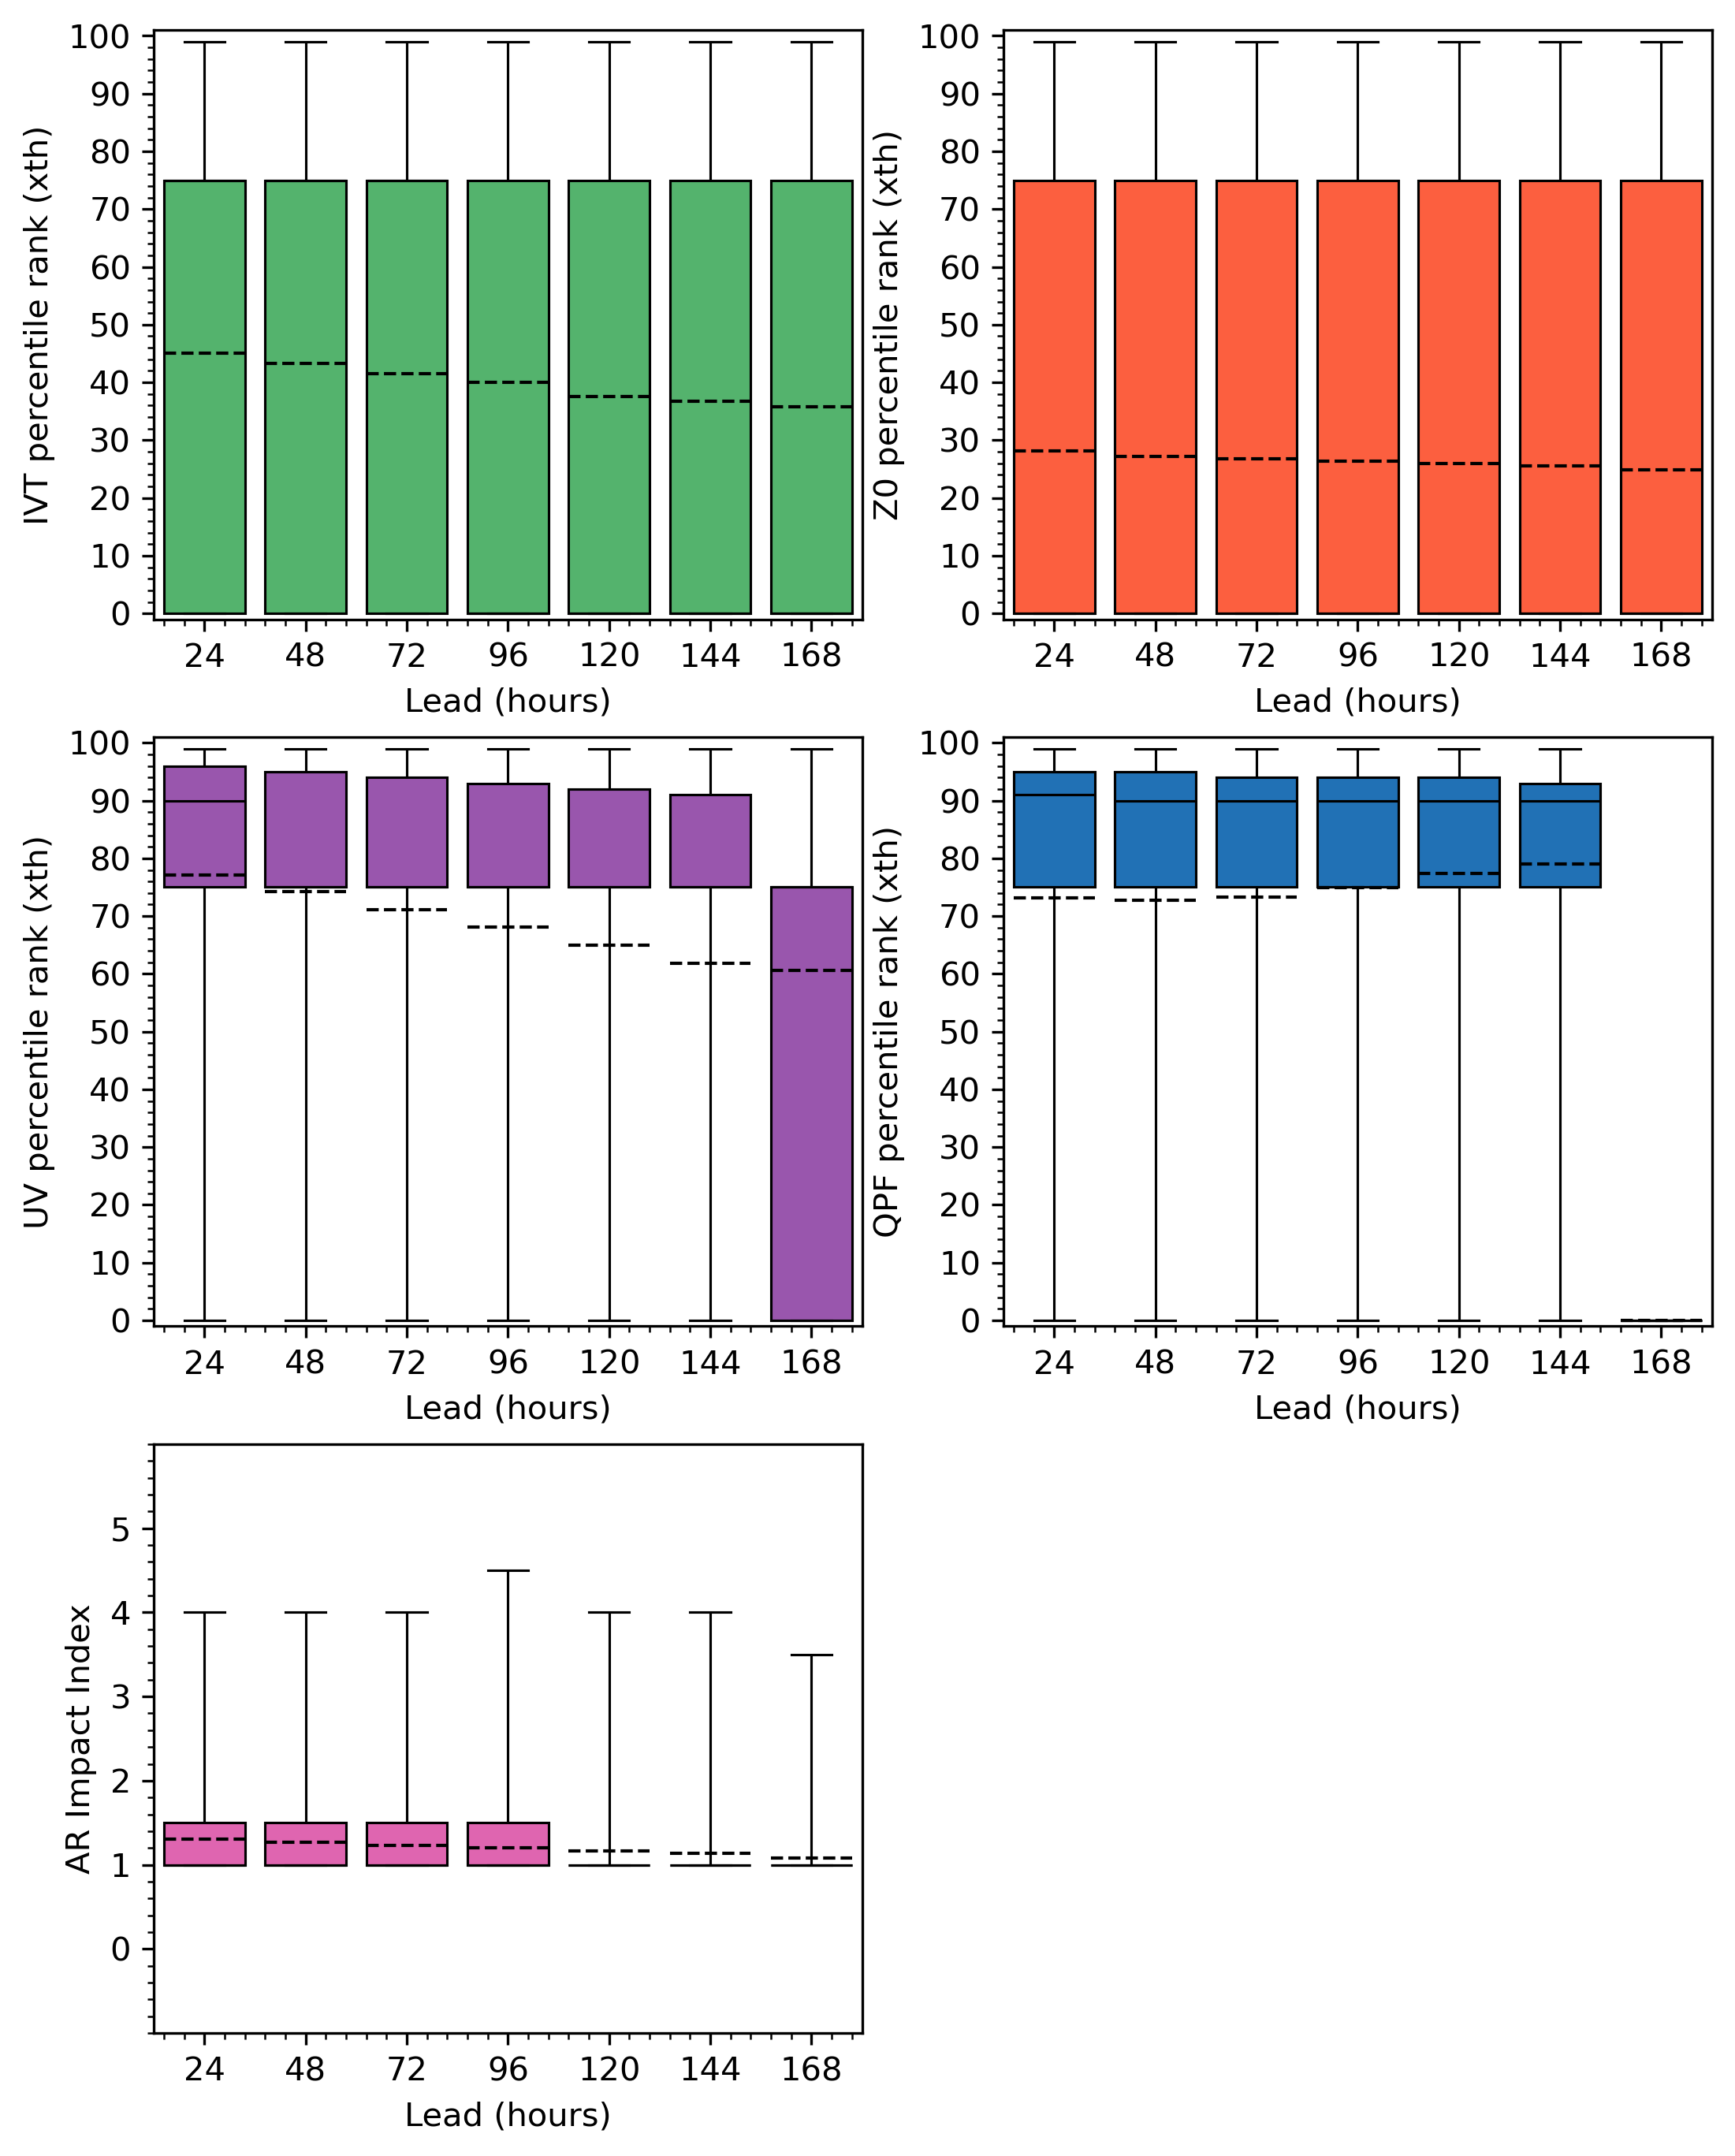

In [7]:
# Create figure
fig = plt.figure(figsize=(8.5, 11))
fig.dpi = 300
fname = path_to_figs + 'non_landslide_box_whisker_{0}'.format(ssn)
fmt = 'png'

nrows = 3
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1], width_ratios = [1, 1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
varname_lst = ['IVT', 'Z0', 'UV', 'QPF', 'AR_index']
color_lst = ['#54B36D', '#FC5F3F', '#9956AD', '#2171b5', '#DF65B0']
row_lst = [0, 0, 1, 1, 2]
col_lst = [0, 1, 0, 1, 0]
for i, varname in enumerate(varname_lst):
    ax = fig.add_subplot(gs[row_lst[i], col_lst[i]])
    PROPS = {'boxprops':{'facecolor':color_lst[i], 'edgecolor':'k'},
             'medianprops':{"color": "k"},
             'whiskerprops':{"color": "k"},
             'capprops':{"color": "k"},
             'flierprops':{"marker": "x"},
             'meanprops':{'c':'k', 'lw':1},
             'bootstrap': 5000}
    
    bplot = sns.boxplot(y=varname, x="F", data=df, 
                        whis=[0, 100],
                    order=np.arange(24, 8*24, 24),
                    meanline=True, showmeans=True, 
                    notch=False, showcaps=True,
                    linewidth=0.75,
                    **PROPS)
    
    #  set the ticks first
    if varname == 'AR_index':
        plt.ylim(-1., 6)
        bplot.set_yticks(np.arange(0., 6, 1))
    else:
        plt.ylim(-1., 101)
        bplot.set_yticks(np.arange(0., 101, 10))
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=True)
    ax.tick_params(axis='y', which='major')
    
        
    # ax.set_title('(a)', loc='left')
    # ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
    #         backgroundcolor='white', zorder=100)
    if i <= 3:
        ax.set_ylabel('{0} percentile rank (xth)'.format(varname))
    else:
        ax.set_ylabel('AR Impact Index')
    ax.set_xlabel('Lead (hours)')


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()